General & Temporial Analysis
===================

This is a series of notebooks used on my research of the literature review on the iterated prisoner's dilemma.

This section follows a circumstantial review of the prisoner's dilemma timeline
conducted by the authors. The section focuses on the analysis of the 
prisoner's dilemma timeline using a large dataset of prisoner's dilemma articles'
metadata.

Using various machine learning techniques the number and topics that have been
researched over the years within the field are discussed. Moreover, we 
explore the connections of the authors that have work on the game using
network theory.


Data collection
-----------------

Academic articles are accessible through scholarly databases and collections of
journals. Several databases and collections today offer access through an open 
Api. An Api is an application protocol interface that allows users to talk
directly the database, skipping the user interface side of a journal.
Interacting with the Api has two phases:


- requesting;
- receiving;


The requesting phase includes composing a url with the requesting message.
The head of the url includes the address of the Api and the tail the search 
argument, such as the word 'prisoner' to exists within the title. The address 
of the Api and the search arguments themselves differ from journal to journal, 
thus different journals can generate complete different requesting urls. 

The second phase of the receiving includes receiving a number of raw metadata of
articles that satisfied the request. The answer is commonly received in an xml
format but similarly the number of features and the syntax of the xml file 
differs from journal to journal.

Data collection is a crucial proceeder. We wanted to include a large number of
articles from various journal for the analysis to be objective. Moreover, we 
wanted the data to be collected within a short period of time. For these reasons
an open source library was developed for the purpose of this work. The library
is called Arcas and though the package it self will not be analysed here the 
source code can be found here, https://github.com/Nikoleta-v3/Arcas. 

Arcas serves as a translator between us and various Apis. More specifically it
works in coordinate with five different journal. For Arcas to collect data a series
of keywords had to be specified. Each keyword individually is checked weather
it exists within the title or the abstract of an article. Only if this check is
satisfied an article is collected.

In [1]:
import pandas as pd
import numpy as np

The open source python library [pandas](http://pandas.pydata.org/) will be used through out this article for the analysis.

In [2]:
df = pd.read_json('../data/data_nov_2017.json')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10987 entries, 0 to 9999
Data columns (total 14 columns):
abstract           10987 non-null object
author             10987 non-null object
date               10987 non-null int64
journal            10987 non-null object
key                10987 non-null object
key_word           10987 non-null object
labels             10987 non-null object
list_strategies    10987 non-null object
pages              10987 non-null object
provenance         10987 non-null object
read               10987 non-null object
score              10987 non-null object
title              10987 non-null object
unique_key         10987 non-null object
dtypes: int64(1), object(13)
memory usage: 1.3+ MB


Pandas info function shows us the information of the data set itself. 

We can see that the sata set contains the following columns:
- Abstract. The abstract of the article.
- Author. A single entity of an author from the list of authors of the respective article.
- Date. Date of publication.
- Journal. Journal of publication. 
- Key. A generated key containing an authors name and publication year (ex. Glynatsi2017).                
- Key_word. A signle entity of a keyword assigned to the article by the given journal.
- Labels. A single entity of labels assigned to the article manual by us.                 
- Pages. Pages of publication.              
- Provenance. Scholarly database for where the article was collected.                 
- Score. Score given to article by the given journal.              
- Title. Title of article.              
- Unique key.  A unique key generated using the [hashlib python library](https://docs.python.org/2/library/hashlib.html). The hashable string is created by: [author name, title, year,abstract]


The data set also contains the columns `list of strategies` and `read` but they are droped for this analysis.

In [38]:
df = df.drop(['read', 'list_strategies'], 1)

In [39]:
df.describe()

,date
count,10943.00000
mean,2009.69798
std,5.96320
min,1944.00000
25%,2007.00000
50%,2010.00000
75%,2013.00000
max,2017.00000


Using the describe function of pandas we can see that there are in total 10990 rows of data
in our data set. Only date is displayed because is the only integer value in the data set. 
The min year is 1944 and the max 2017. 

**Total number of articles.**

In [40]:
total_articles = len(df['unique_key'].unique())
total_articles

1143

In [41]:
file = open("/home/nightwing/rsc/Literature-Article/assets/total_articles.txt", 'w')
file.write('{}'.format(total_articles))
file.close()

There are in total 1152 articles within the data set.

In [42]:
df = df.replace('None', np.nan)

**Unique titles**

In [23]:
len(df['title'].unique()), len(df['unique_key'].unique())

(1144, 1150)

In [24]:
unique_titles = len(df['title'].unique())

In [25]:
file = open("/home/nightwing/rsc/Literature-Article/assets/unique_titles.txt", 'w')
file.write('{}'.format(unique_titles + 1))
file.close()

In [26]:
number_of_duplicates = total_articles - (unique_titles + 1)
number_of_duplicates

5

In [27]:
file = open("/home/nightwing/rsc/Literature-Article/assets/number_of_duplicates.txt", 'w')
file.write('{}'.format(number_of_duplicates))
file.close()

**Numbers of author and year range.**

In [34]:
number_of_authors = len(df['author'].unique())
number_of_authors

2101

In [35]:
file = open("/home/nightwing/rsc/Literature-Article/assets/number_of_authors.txt", 'w')
file.write('{}'.format(number_of_authors))
file.close()

Provenance
----------

The total number of articles is given above. Here we can illustrate the provenance of these articles.
Thus we can see from which journal they have been collected and how many articles have been added by us. The table below shows the number of articles for each provenance.

In [43]:
provenance_size = df.groupby(['unique_key', 'provenance']).size().reset_index().groupby('provenance').size()

In [44]:
file = open("/home/nightwing/rsc/Literature-Article/assets/prov_maual.txt", 'w')
file.write('{}'.format(provenance_size ['Manual']))
file.close()

In [45]:
provenance_table = pd.DataFrame(provenance_size, columns=['Number of articles'])

In [46]:
provenance_table.index.names = ['Provenance']

In [47]:
provenance_table

,Number of articles
Provenance,
IEEE,241
Manual,41
Nature,23
PLOS,63
Springer,310
arXiv,465


In [48]:
file = open("/home/nightwing/rsc/Literature-Article/assets/provenance_table.tex", 'w')
file.write('{}'.format(provenance_table.to_latex()))
file.close()

As mentioned before not all results from each API have the same format and same information. For example keywords our only given by IEEE and nature. Furthermore not all journals had full information for specific articles. 

Here we will look at the percentage of coverage of each column

In [22]:
temp = df.drop_duplicates('unique_key')
for col in df.columns:
    
    perc = len(temp[col].dropna()) / len(temp) 
    perc *= 100
    print(col, ":", round(perc, 2))

abstract : 97.39
author : 100.0
date : 100.0
journal : 99.48
key : 100.0
key_word : 21.65
labels : 11.57
pages : 24.52
provenance : 100.0
score : 6.35
title : 100.0
unique_key : 100.0


Temporal Analysis
-----------------

In the general analysis section we looked at the number of articles collected from each journal and wheather they have been added manually.

In Figure Provenance the number of articles collected per year and per API are illustrated. Springer seems to have a continuous contribution on the data set from 1996 up to 2016. The total number of articles collected from Springer per year do not exceed 30. On the other hand, IEEE and arXiv, where both have a significant contribution to the data set, seem to have articles on the IPD only after the 2000s. Finally, both Nature and PLOS with a small significant contribution appear after the 2010s.

In [2]:
df = pd.read_json('../data/data_dec_2017_clean.json')

In [6]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

In [4]:
font = {'size'   : 10,
        'weight': 'bold'}
matplotlib.rc('font', **font)

In [7]:
yearly_provenance = df.groupby(['unique_key','provenance', 'date']).size().reset_index().groupby(['provenance', 'date']).size()

In [8]:
yearly_df = df.groupby(['unique_key', 'date']).size().reset_index().groupby('date').size()

In [9]:
colors = list(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = [':', '--', '-', '--', '-', '--']

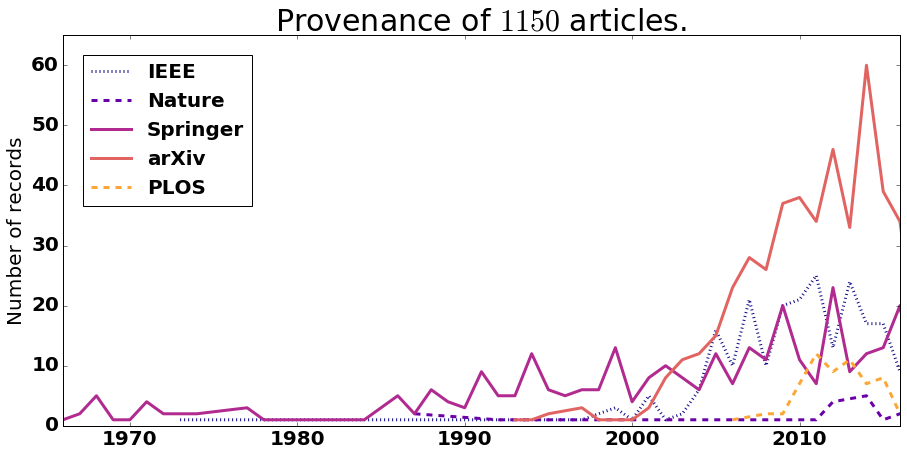

In [29]:
fig = plt.figure(figsize=(15, 7))

plt.title('Provenance of ${}$ articles.'.format(total_articles), fontsize=30)
plt.ylabel('Number of records', fontsize=20); plt.ylim([0, 65]); plt.yticks(fontsize=20)
plt.xticks(fontsize=20); plt.xlim(1966,2016)
    
plt.plot(yearly_provenance['IEEE'], linestyle=linestyles[0], 
         label="IEEE", linewidth=3, c=colors[0])
plt.plot(yearly_provenance['Nature'], linestyle=linestyles[1],
         label="Nature", linewidth=3, c=colors[1])
plt.plot(yearly_provenance['Springer'],
         label="Springer", linewidth=3, linestyle=linestyles[2], c=colors[2])
plt.plot(yearly_provenance['arXiv'], linestyle=linestyles[4],
         label="arXiv", linewidth=3, c=colors[3])
plt.plot(yearly_provenance['PLOS'], linestyle=linestyles[5],
         label="PLOS", linewidth=3, c=colors[4])

plt.legend(loc=2, borderaxespad=1, fontsize=20)
plt.savefig("/home/nightwing/rsc/Literature-Article/assets/images/provenance.pdf", bbox_inches='tight')

In [56]:
label = []
for y in range(min(yearly_df.index), max(yearly_df.index + 1)):
    if y%10 == 0:
        label.append(y)
    else:
        label.append(None)

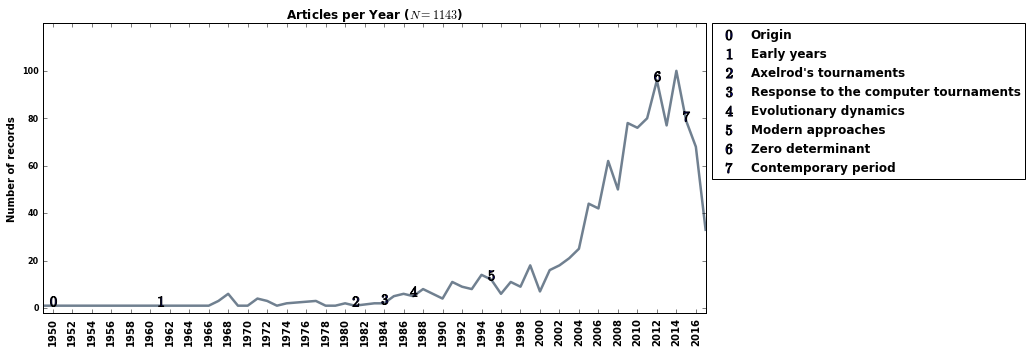

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.title('Articles per Year ($N={}$)'.format(total_articles), fontweight='bold');plt.ylabel('Number of records', fontweight='bold')
ax.plot(yearly_df, color='slategray', zorder=1, linewidth=2.5)
plt.xticks(fontsize=10); plt.yticks(fontsize=8)

colors = iter(matplotlib.cm.viridis(np.linspace(0, 1, 15)))
milestones = [1950, 1961, 1981, 1984, 1987, 1995, 2012, 2015]
labels = ['Origin', "Early years", "Axelrod's tournaments", 
          "Response to the computer tournaments", "Evolutionary dynamics", 
          "Modern approaches", "Zero determinant", "Contemporary period"]
height = [yearly_df[yearly_df.index == y].values for y in milestones]

height = [yearly_df[yearly_df.index == y].values for y in milestones]

for i, m in enumerate(milestones):
    h = yearly_df[yearly_df.index == m].values
#     c = next(colors)
    ax.scatter(m, (h + 2), marker="${}$".format(i), s=100, zorder=2, label=labels[i]);
    #ax.annotate(i, color=c, xy=(m, h), fontsize=100, fontweight='bold', zorder=2)

x = yearly_df.index
y = yearly_df.values

ax.set_yticks(np.arange(min(y) - 1, max(y)+1, 20.0))
ax.set_xticks(np.arange(min(x), max(x)+1, 2.0))
ax.set_ylim(ymin=-2)
ax.set_xlim(xmin=1949, xmax=2017)
plt.xticks(rotation=90)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., scatterpoints=1);
plt.savefig("/home/nightwing/rsc/Literature-Article/assets/images/timeline.pdf",
           format='pdf', bbox_inches='tight')

**First article of a journal.**

In [24]:
df[(df['provenance'] == 'Nature') & (df['author'] == 'martin a. nowak')].sort_values('date')

,abstract,author,date,journal,key,key_word,labels,list_strategies,pages,provenance,read,score,title,unique_key
10972,None,martin a. nowak,1992,Nature,Nowak1992,None,noise,None,250-253,Nature,True,None,Tit for tat in heterogeneous populations,key03
10973,None,martin a. nowak,1992,Nature,Nowak1992,None,strategic rules,None,250-253,Nature,True,None,Tit for tat in heterogeneous populations,key03
995,<p>Two players engaged in the Prisoner's Dilem...,martin a. nowak,1993,Nature Publishing Group,Nowak1993,None,strategic rules,None,None,Nature,True,None,"A strategy of win-stay, lose-shift that outper...",1a17155cd3f29b9efa8a1750eee4c654


In [25]:
journals = ['IEEE', 'Nature', 'PLOS', 'arXiv', 'Springer']

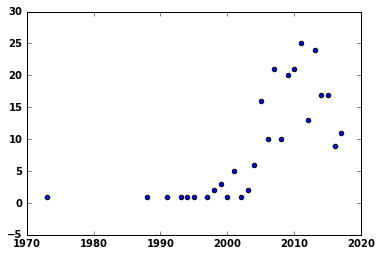

In [27]:
for j in [journals[0]]:
    plt.scatter(yearly_provenance[j].index, yearly_provenance[j].values)